**NER**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa_up_to_date.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()
print(raot_cta_ner.shape)

11998
(1270861, 14)


In [3]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('12/20/2021')
end_date = pd.to_datetime('10/09/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [4]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.head()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
417941,2021-12-20,60889867b73a210003635f47,61c09dbaf4dff2002a02dd04,2021-12-20,New York,4cc4ac96-1a4c-35cd-3de6-360319223ef5,"New York, NY",22194904-01fc-2cfa-81bd-dc97a1cb6e2b,Newark/Orange/East Essex County,8044e3e8b4b5112d29c08636ead8990c,2586.700892,2585.693451,224.0,224.0
1058548,2021-12-20,5fc566f730840e00034de13e,GENERATED,2021-12-20,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Champions/FM 1960,37aa3c257e7c366776ca569c1b66c014,NaN,915.681818,NaN,440.0
1193124,2021-12-20,5c702b146582000015a3551c,GENERATED,2021-12-20,Oregon,bb3403f2-1a88-5959-3ee9-b369eab25b9a,"Portland, OR",1ac6ab71-5209-9f74-4e4b-f5a746648edb,Tigard/Oswego/Wilsonville,bb7665a2ac36710312a5953ba2532021,NaN,1810.000000,NaN,372.0
1233940,2021-12-20,5eb44ea19aee9c0004afacda,GENERATED,2021-12-20,Florida,de4bebc6-220a-8701-3dae-c1612fdd70d6,"Tallahassee, FL",e165338e-950d-6181-3074-eeea43aa5d2d,Other,cfc9b3ebda6d87ab30d7f4b95fdb969e,NaN,960.657894,NaN,152.0
1244526,2021-12-20,5de809bcd70cda001d16f1d6,GENERATED,2021-12-20,Washington,29f94770-3b3e-9adc-491b-dd6422b92859,"Bremerton, WA",0c01a359-7756-5857-4591-8710e73d2a4a,Other,fdad6cc139403d17a1cdd4789608ecbd,NaN,2032.761764,NaN,170.0


In [5]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4']]

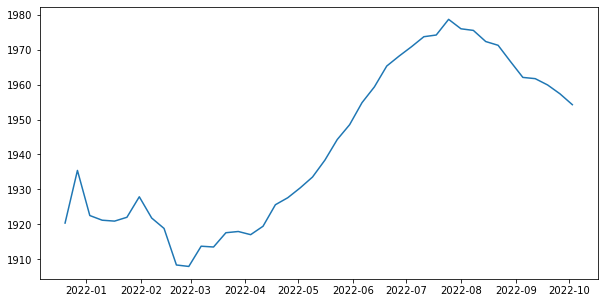

In [6]:
avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'NER_T4':'mean'}).reset_index()

plt.figure(figsize=(10, 5))
plt.plot(avg_ner_data['WEEK_START'], avg_ner_data['NER_T4'])

In [7]:
msa_data = pd.read_csv('msa_data.csv')

In [14]:
msa_data_lst = list(msa_data['MSA'])

In [15]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4')

In [16]:
pct_change_msa = []

for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
        start_ner = subset['NER_T4'][0]
        end_ner = subset['NER_T4'][-1]
        percent_change = ((end_ner - start_ner) / start_ner) * 100
        pct_change_msa.append(percent_change)
        print(f'pct_change year_to_date for {unique_val} was {percent_change}')

pct_change year_to_date for Atlanta, GA was -1.0178553115670101
pct_change year_to_date for Austin, TX was 6.16089593556192
pct_change year_to_date for Baltimore, MD was -6.755959279533006
pct_change year_to_date for Boston, MA was 4.839233814587586
pct_change year_to_date for Charleston, SC was 4.187016413294529
pct_change year_to_date for Charlotte, NC was 4.944987223690679
pct_change year_to_date for Chicago, IL was 10.921788994943094
pct_change year_to_date for Dallas, TX was 0.06453755308976016
pct_change year_to_date for Denver, CO was 6.760269420807469
pct_change year_to_date for Houston, TX was 1.665135623742007
pct_change year_to_date for Jacksonville, FL was -2.939188896846943
pct_change year_to_date for Las Vegas, NV was -5.3430720039625115
pct_change year_to_date for Los Angeles, CA was 1.4630212298029608
pct_change year_to_date for Miami, FL was 4.1585531862453164
pct_change year_to_date for Nashville, TN was -0.29539120334881047
pct_change year_to_date for New York, NY wa

In [17]:
msa_data['pct_change'] = pct_change_msa
msa_data

,MSA,pct_change
0,"Atlanta, GA",-1.017855
1,"Austin, TX",6.160896
2,"Baltimore, MD",-6.755959
3,"Boston, MA",4.839234
4,"Charleston, SC",4.187016
5,"Charlotte, NC",4.944987
6,"Chicago, IL",10.921789
7,"Dallas, TX",0.064538
8,"Denver, CO",6.760269
9,"Houston, TX",1.665136


In [18]:
xg_boost_predictions = pd.read_csv('df_xgboost_msa_level_SAME_STORE.csv')
predictions = pd.read_csv('df_prophet_msa_level.csv')

In [19]:
predictions['xgboost_predictions'] = xg_boost_predictions['Predictions']
predictions = predictions[['Time', 'MSA', 'Predictions', 'xgboost_predictions']]
predictions = predictions.rename({'Time' : "Date", 'MSA' : 'MSA', 'Predictions':'prophet_predictions', 'xgboost_predictions':'xgboost_predictions'}, axis='columns')

In [20]:
predictions['ensemble model 1'] = (predictions['xgboost_predictions'] + predictions['prophet_predictions']) / 2
predictions['ensemble model 2'] = (2*predictions['xgboost_predictions'] + predictions['prophet_predictions']) / 3

In [21]:
predictions

,Date,MSA,prophet_predictions,xgboost_predictions,ensemble model 1,ensemble model 2
0,2022-04-18,"Atlanta, GA",1852.974134,1788.1614,1820.567767,1809.765645
1,2022-04-25,"Atlanta, GA",1856.357889,1793.0377,1824.697794,1814.144430
2,2022-05-02,"Atlanta, GA",1859.583054,1787.4612,1823.522127,1811.501818
3,2022-05-09,"Atlanta, GA",1847.191861,1785.5348,1816.363331,1806.087154
4,2022-05-16,"Atlanta, GA",1819.918317,1788.8810,1804.399659,1799.226772
...,...,...,...,...,...,...
695,2022-09-05,"Washington, DC",2239.443449,2163.0370,2201.240225,2188.505816
696,2022-09-12,"Washington, DC",2257.842157,2169.7407,2213.791428,2199.107852
697,2022-09-19,"Washington, DC",2266.610812,2156.1519,2211.381356,2192.971537
698,2022-09-26,"Washington, DC",2255.807036,2164.6992,2210.253118,2195.068479


In [41]:
subsets = dict((x, y) for x, y in predictions.groupby(['MSA']))

In [42]:
pct_change_prophet_msa = []
pct_change_xgboost_msa = []
pct_change_ensemble_model_1_msa = []
pct_change_ensemble_model_2_msa = []

def pct_change(old, new):
    percent_change = ((new - old) / old) * 100
    return percent_change
    

for unique_val, subset in subsets.items():
    prophet_predictions = list(subset['prophet_predictions'])
    pct_change_prophet_msa.append(pct_change(prophet_predictions[0], prophet_predictions[-1]))
    
    xgboost_predictions = list(subset['xgboost_predictions'])
    pct_change_xgboost_msa.append(pct_change(xgboost_predictions[0], xgboost_predictions[-1]))
    
    ensemble_model_1 = list(subset['ensemble model 1'])
    pct_change_ensemble_model_1_msa.append(pct_change(ensemble_model_1[0], ensemble_model_1[-1]))
    
    ensemble_model_2 = list(subset['ensemble model 2'])
    pct_change_ensemble_model_2_msa.append(pct_change(ensemble_model_2[0], ensemble_model_2[-1]))

In [43]:
msa_data['prophet_predictions'] = pct_change_prophet_msa
msa_data['xgboost_predictions'] = pct_change_xgboost_msa
msa_data['ensemble_model_1_predictions'] = pct_change_ensemble_model_1_msa
msa_data['ensemble_model_2_predictions'] = pct_change_ensemble_model_2_msa

msa_data

,MSA,pct_change,prophet_predictions,xgboost_predictions,ensemble_model_1_predictions,ensemble_model_2_predictions
0,"Atlanta, GA",-1.017855,9.101799,5.141616,7.156954,6.493194
1,"Austin, TX",6.160896,13.203637,2.939532,8.167412,6.446613
2,"Baltimore, MD",-6.755959,2.709482,0.110887,1.430740,0.995454
3,"Boston, MA",4.839234,4.663763,2.443641,3.572147,3.200168
4,"Charleston, SC",4.187016,5.637682,-0.142891,2.834147,1.861858
5,"Charlotte, NC",4.944987,6.924775,1.572635,4.310828,3.412332
6,"Chicago, IL",10.921789,6.763581,5.147117,5.982146,5.710024
7,"Dallas, TX",0.064538,7.617685,1.633137,4.700232,3.695053
8,"Denver, CO",6.760269,5.380413,0.534740,2.997066,2.185258
9,"Houston, TX",1.665136,5.770744,3.983685,4.896863,4.596965


In [44]:
msa_data.to_csv("df_prediction_comparsion.csv")